<a href="https://colab.research.google.com/github/sclatch1/ir2/blob/main/test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%pip install -U sentence-transformers


In [ ]:
%pip install kneed[plot]

In [ ]:
from sentence_transformers import SentenceTransformer

In [ ]:
import pandas as pd
from pathlib import Path
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from kneed import KneeLocator
import numpy as np

In [ ]:
DATA_DIR = Path.cwd() / "data"



def csv_to_df():
    corpus = []
    for file_path in DATA_DIR.iterdir():
        df = pd.read_csv(file_path)
        corpus.append(df)
    return pd.concat(corpus).sort_values(by="title").reset_index(drop=True)
df_corpus = csv_to_df()

In [ ]:
model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')
embeddings = model.encode(df_corpus["plot"].to_list())

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [ ]:
print(type(embeddings))

<class 'numpy.ndarray'>


In [ ]:
def compute_rss(data, labels, centers):
    rss = 0.0
    for k in range(len(centers)):
        cluster_points = data[labels == k]
        rss += np.sum((cluster_points - centers[k]) ** 2)
    return rss


In [ ]:
def estimate_rss_min(data, K, runs=10):
    rss_values = []
    for _ in range(runs):
        km = KMeans(n_clusters=K, n_init=1, random_state=None)
        labels = km.fit_predict(data)
        rss = compute_rss(data, labels, km.cluster_centers_)
        rss_values.append(rss)
    return min(rss_values)

In [ ]:
N = embeddings.shape[0]
K_values = list(range(2, 15))

rss_min_values = []

for K in K_values:
    rss_k = estimate_rss_min(embeddings, K, runs=10)
    rss_min_values.append(rss_k)

Detected elbow (knee): 7


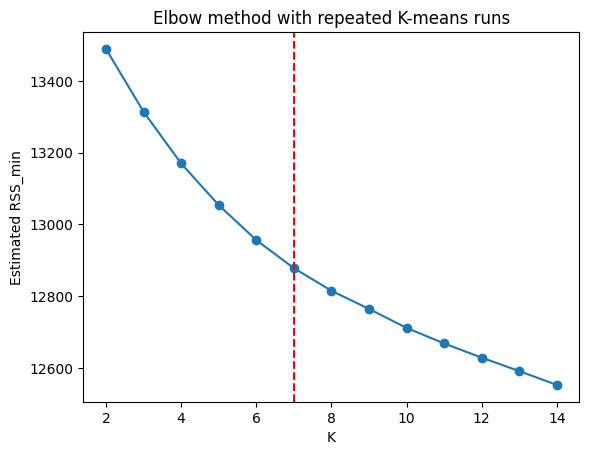

In [ ]:
# Find knee
knee = KneeLocator(
    K_values, rss_min_values,
    curve='convex', direction='decreasing'
)

print("Detected elbow (knee):", knee.knee)

# Plot
plt.plot(K_values, rss_min_values, marker='o')
plt.axvline(knee.knee, color='r', linestyle='--')
plt.xlabel("K")
plt.ylabel("Estimated RSS_min")
plt.title("Elbow method with repeated K-means runs")
plt.show()


In [ ]:
import math
K = int(embeddings.shape[0] / 512)
# TODO: try with k = 7

kmeans = KMeans(n_clusters=K, random_state=42, n_init="auto")
labels = kmeans.fit_predict(embeddings)
centroids = kmeans.cluster_centers_


/usr/local/lib/python3.12/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(
/tmp/ipython-input-1292717101.py:18: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('hsv', 7)


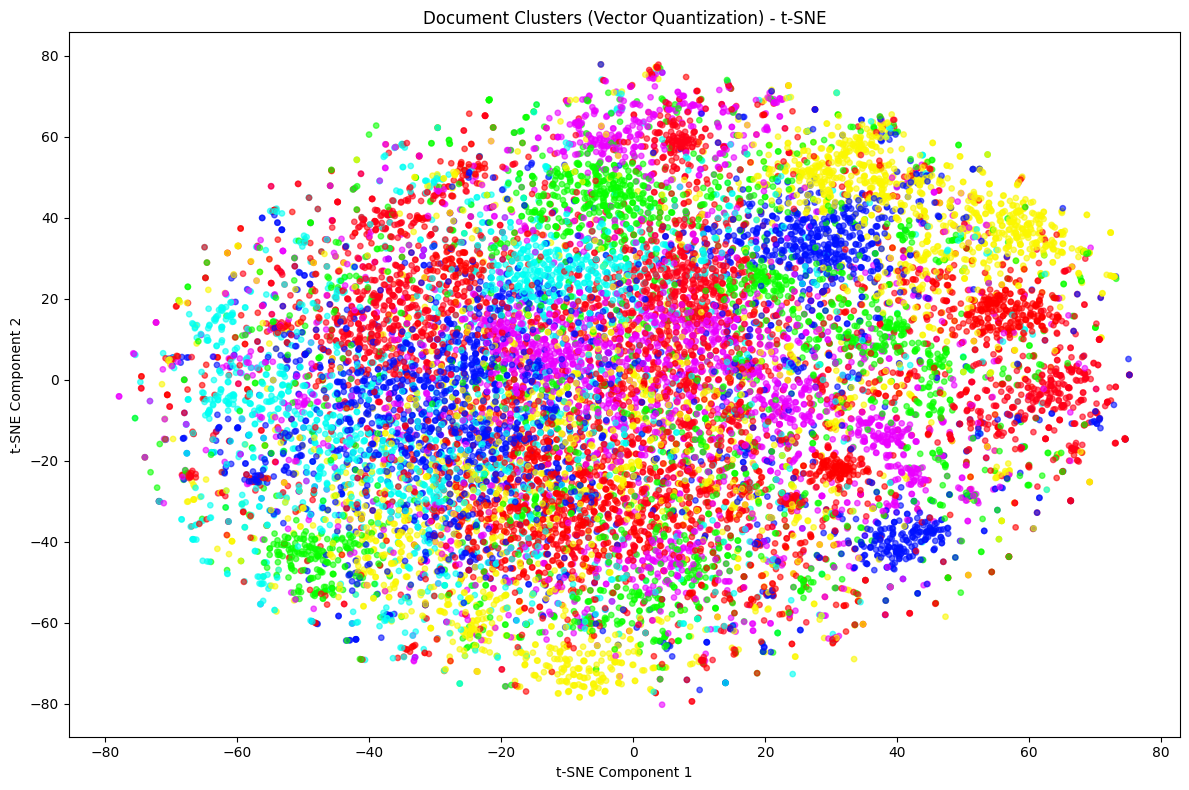

In [ ]:
labels = kmeans.labels_
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

# Assume:
# embeddings: your document embeddings (N x D)
# labels: KMeans cluster labels (N, values 0..132)

# --- Step 1: Reduce embeddings to 2D with t-SNE ---
tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=1000)
X_2d = tsne.fit_transform(embeddings)

# --- Step 2: Plot ---
plt.figure(figsize=(12, 8))

# Use a colormap with 7 distinct colors
cmap = plt.cm.get_cmap('hsv', 7)

plt.scatter(X_2d[:, 0], X_2d[:, 1], c=labels, cmap=cmap, alpha=0.6, s=15)

plt.title("Document Clusters (Vector Quantization) - t-SNE")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")

plt.tight_layout()
plt.show()


In [ ]:
posting_lists = {i: [] for i in range(K)}

for idx, label in enumerate(labels):
    posting_lists[label].append(idx)

"""
# Query Processing
query = np.random.rand(embeddings.shape[1]) # Changed query dimension to match embeddings
nearest_centroid = np.argmin([np.linalg.norm(query - centroid) for centroid in kmeans.cluster_centers_])

# Fine Search (Within the posting list of nearest centroid)
nearest_vectors = [embeddings[i] for i in posting_lists[nearest_centroid]] # Changed 'vectors' to 'embeddings'
closest_vector = min(nearest_vectors, key=lambda x: np.linalg.norm(query - x))

print(f"Nearest vector: {closest_vector}")
"""


'\n# Query Processing\nquery = np.random.rand(embeddings.shape[1]) # Changed query dimension to match embeddings\nnearest_centroid = np.argmin([np.linalg.norm(query - centroid) for centroid in kmeans.cluster_centers_])\n\n# Fine Search (Within the posting list of nearest centroid)\nnearest_vectors = [embeddings[i] for i in posting_lists[nearest_centroid]] # Changed \'vectors\' to \'embeddings\'\nclosest_vector = min(nearest_vectors, key=lambda x: np.linalg.norm(query - x))\n\nprint(f"Nearest vector: {closest_vector}")\n'

In [ ]:
query = embeddings[9645] # document 9645

def search(query_vec, top_m=5):
    # 1. Find nearest centroid (coarse search)
    distances = np.linalg.norm(centroids - query_vec, axis=1)
    nearest_cluster = np.argmin(distances)

    # 2. Fine search in posting list
    candidate_ids = posting_lists[nearest_cluster]
    candidate_vecs = embeddings[candidate_ids]

    fine_dists = np.linalg.norm(candidate_vecs - query_vec, axis=1)
    top_idx = np.argsort(fine_dists)[:top_m]

    return [(candidate_ids[i], fine_dists[i]) for i in top_idx]

search(query)

[(9645, np.float32(0.0)),
 (4420, np.float32(0.9594264)),
 (16024, np.float32(0.97392005)),
 (14226, np.float32(1.0147237)),
 (105, np.float32(1.0193325))]

In [ ]:


print(df_corpus.loc[9645, "plot"])
print(df_corpus.loc[1098, "plot"])
print(df_corpus.loc[10260, "plot"])
print(df_corpus.loc[13685, "plot"])

#print(df_corpus.loc[105, "title"])
#print(df_corpus.loc[9645, "title"])

Michael is a high school graduate living in North Hollywood, California with dreams of becoming a professional skateboarder. After being noticed by two professional skaters, Michael quits his water polo team to focus exclusively on skating. This leads to tension within Michael's relationship with his friends and his father. Michael thinks that his friends, Jay and Adolf, are not taking skating as seriously as him and he does not want to waste time with them. For this reason he starts to skate with them less and more with the professional skaters, which adds to the tension in their relationships. His father does not see skating as a realistic career and wants him to go to college and pursue stable employment. Michael is ultimately faced with the decision between choosing the future his father wants, or following his dream of becoming a professional skater.
History professor Michael (Harry Connick Jr.) as a child loved Christmas, but as an adult is less than enthused about it. His family

In [1]:
class storage(object):
  def __init__(self, storage_config, table_id):
    self.storage_config = storage_config
    self.table_id = table_id
    self.table = {}
    self.table_size = 0
    self.table_count = 0
    self.max_table_size = storage_config["max_table_size"]



In [ ]:
class lsh(object):
  def __init__(self, hash_size, input_dim, num_tables):
    self.hash_size = hash_size
    self.input_dim = input_dim
    self.num_tables = num_tables


  def _init_uniform_planes(self):
    self.uniform_planes = [self._generate_uniform_plane() for _ in xrange(self.num_hashtables)]

  def _init_hashtables(self):
    """ Initialize the hash tables such that each record will be in the
    form of "[storage1, storage2, ...]" """

    self.hash_tables = [storage(self.storage_config, i)
                        for i in xrange(self.num_hashtables)]

  def _generate_uniform_plane(self):
    return np.random.randn(self.hash_size, self.input_dim)

  def _hash(self, planes, input_point):
    input_point = np.array(input_point)
    projections = np.dot(planes, input_point)

  def index(self, input_point):
    if isinstance(input_point, np.ndarray):
      input_point = input_point.tolist()

    value = tuple(input_point)

    for i, table in enumerate(self.hash_tables):
      hash_value = self._hash(self.uniform_planes[i], input_point)
      table.insert(hash_value, input_point, value)

  def query(self, query_point, num_results=None, distance_func=None):
        """ Takes `query_point` which is either a tuple or a list of numbers,
        returns `num_results` of results as a list of tuples that are ranked
        based on the supplied metric function `distance_func`.

        :param query_point:
            A list, or tuple, or numpy ndarray that only contains numbers.
            The dimension needs to be 1 * `input_dim`.
            Used by :meth:`._hash`.
        :param num_results:
            (optional) Integer, specifies the max amount of results to be
            returned. If not specified all candidates will be returned as a
            list in ranked order.
        :param distance_func:
            (optional) The distance function to be used. Currently it needs to
            be one of ("hamming", "euclidean", "true_euclidean",
            "centred_euclidean", "cosine", "l1norm"). By default "euclidean"
            will used.
        """

        candidates = set()
        if not distance_func:
            distance_func = "euclidean"

        if distance_func == "hamming":
            if not bitarray:
                raise ImportError(" Bitarray is required for hamming distance")

            for i, table in enumerate(self.hash_tables):
                binary_hash = self._hash(self.uniform_planes[i], query_point)
                for key in table.keys():
                    distance = LSHash.hamming_dist(key, binary_hash)
                    if distance < 2:
                        candidates.update(table.get_list(key))

            d_func = LSHash.euclidean_dist_square

        else:

            if distance_func == "euclidean":
                d_func = LSHash.euclidean_dist_square
            elif distance_func == "true_euclidean":
                d_func = LSHash.euclidean_dist
            elif distance_func == "centred_euclidean":
                d_func = LSHash.euclidean_dist_centred
            elif distance_func == "cosine":
                d_func = LSHash.cosine_dist
            elif distance_func == "l1norm":
                d_func = lsh.l1norm_dist
            else:
                raise ValueError("The distance function name is invalid.")

            for i, table in enumerate(self.hash_tables):
                binary_hash = self._hash(self.uniform_planes[i], query_point)
                candidates.update(table.get_list(binary_hash))

        # rank candidates by distance function
        candidates = [(ix, d_func(query_point, self._as_np_array(ix)))
                      for ix in candidates]
        candidates.sort(key=lambda x: x[1])

        return candidates[:num_results] if num_results else candidates

